In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score
from src.model_selection import test_model
from sklearn.metrics import confusion_matrix, mean_squared_error
from scipy.stats import pearsonr

In [2]:
from src.processing import import_data
from src.model_selection import test_model
from src.metrics import equalized_odds
from src.visualizations import get_significant_correlations

# Load data

In [3]:
data_init, data_full, data, data_protected, data_y = import_data()

In [4]:
IsBlack = data_full.IsBlack == 1

In [5]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
index_cols = ["IsBlack"]

# DesicionTreeClassifier
## Baseline model

In [6]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


model = DecisionTreeClassifier
model_params = {"max_depth":3, "random_state":1}

preds = test_model(model, X, y, kfold, model_params=model_params)

### Equalized odds regarding black ratio

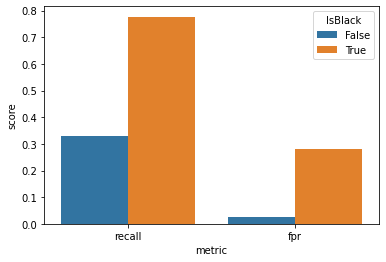

In [8]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [9]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1411
           1       0.80      0.63      0.71       583

    accuracy                           0.85      1994
   macro avg       0.83      0.78      0.80      1994
weighted avg       0.84      0.85      0.84      1994



In [10]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7559429477020603

In [11]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8870139398385913

In [12]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 373.0)

In [13]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 90.0)

## Debias data baseline (desicion tree)

In [14]:
from src.debias_data import debias_data

In [15]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [16]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [17]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = DecisionTreeClassifier
model_params = {"random_state":1}

preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)

### Equalized odds regarding black ratio with unbias data

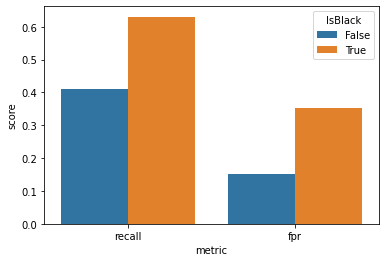

In [19]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [20]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1411
           1       0.56      0.56      0.56       583

    accuracy                           0.74      1994
   macro avg       0.69      0.69      0.69      1994
weighted avg       0.74      0.74      0.74      1994



In [21]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.6370839936608558

In [22]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.7879677182685253

In [23]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(395, 332.0)

In [24]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(188, 255.0)

# Correlations

### Original data, with target variables

In [25]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [26]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]

In [27]:
org_df = X.copy()
org_df[y_cols] = data_y.copy()

<AxesSubplot:>

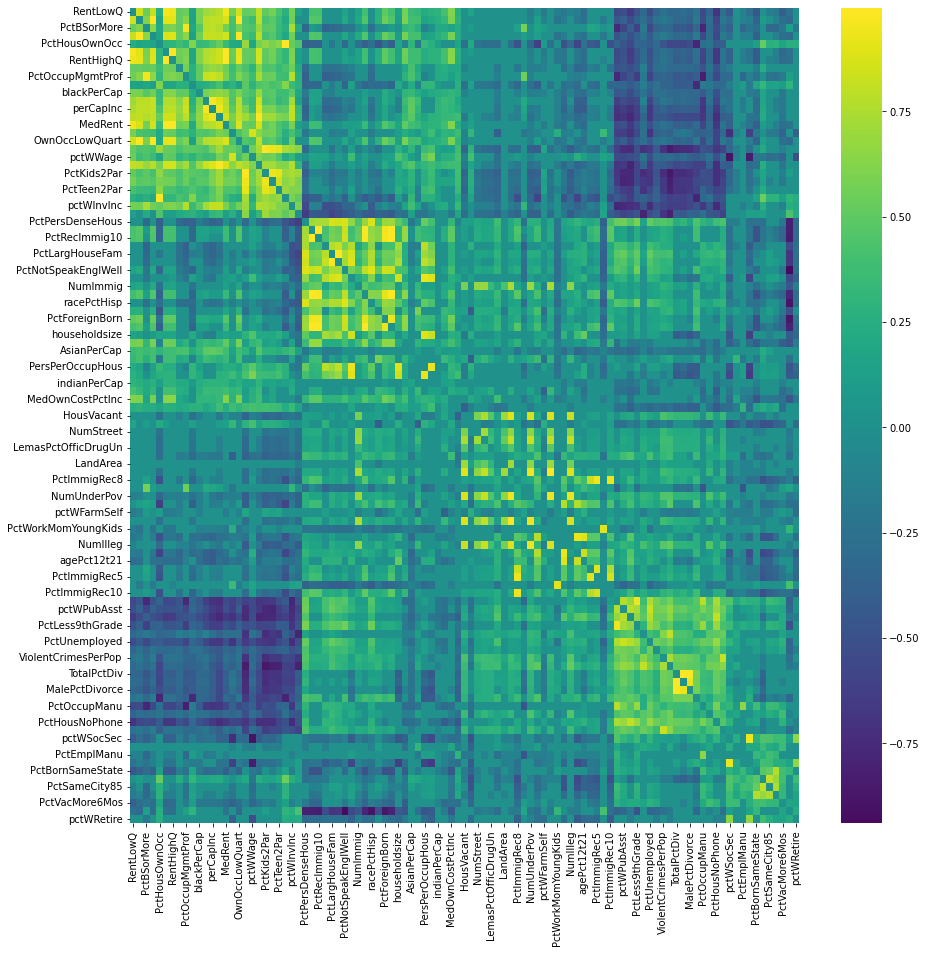

In [28]:
fig, ax = plt.subplots(1, figsize=(15,15))
sns.heatmap(get_significant_correlations(org_df), center=0, annot=False, cmap="viridis")

<AxesSubplot:>

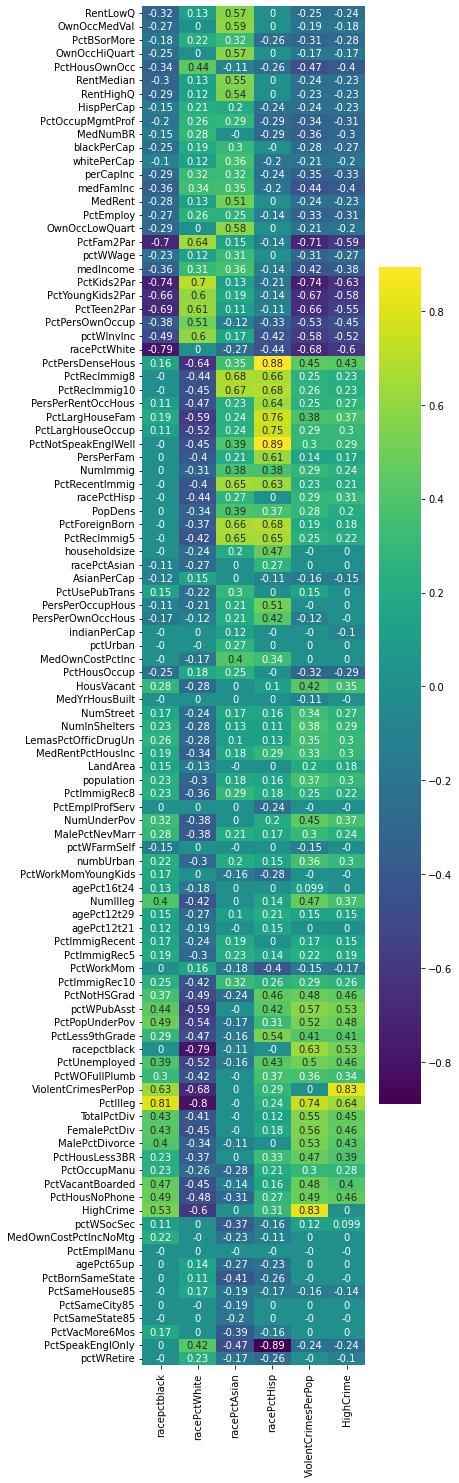

In [29]:
# Same, just showing the protected columns
fig, ax = plt.subplots(1, figsize=(5,25))
sns.heatmap(get_significant_correlations(org_df)[protected_cols + y_cols], center=0, annot=True, cmap="viridis")

## Debiased corrs

In [30]:
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [31]:
debias_df = data_full.copy().drop(columns=y_cols)
debias_array, _ = debias_data(protected_cols, nonprotected_cols)(debias_df, debias_df)

In [32]:
# Add the protected columns and the target columns to the debiased data frame for comparison
debias_df = pd.DataFrame(debias_array, columns=nonprotected_cols)
debias_df[y_cols] = data_y
debias_df[protected_cols] = data_full[protected_cols]

<AxesSubplot:>

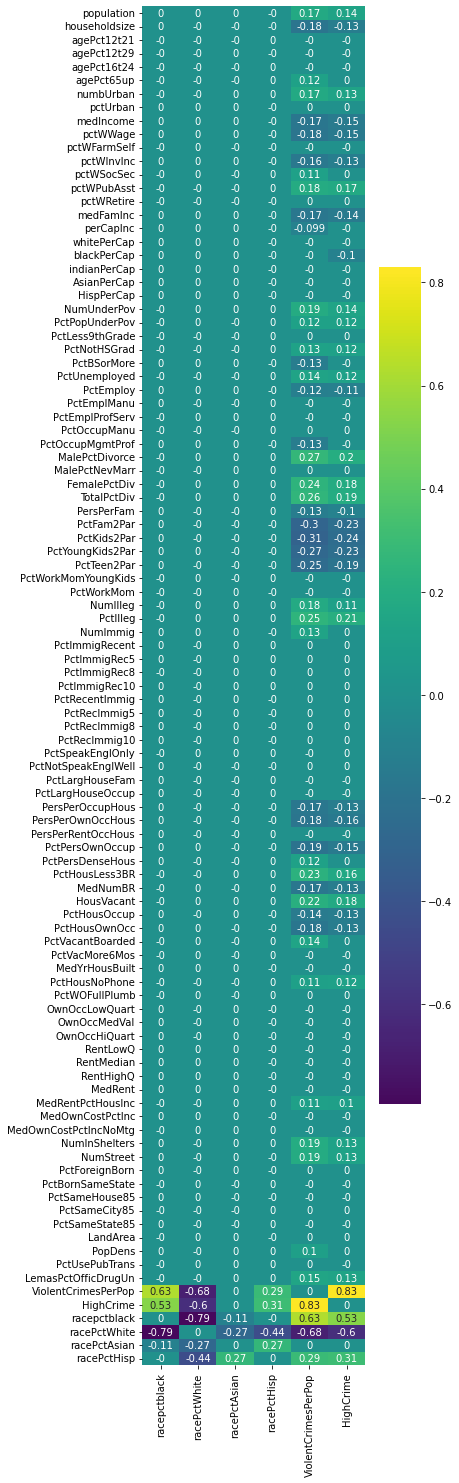

In [33]:
# Show the pearson correlations
pearson_corr = get_significant_correlations(debias_df, cluster=False)
fig, ax = plt.subplots(1, figsize=(5,25))
sns.heatmap(pearson_corr[protected_cols + y_cols], center=0, annot=True, cmap="viridis")

In [34]:
# Speanman corr matrix
speaman_corr = get_significant_correlations(debias_df, cluster=False, method="spearman")

<AxesSubplot:>

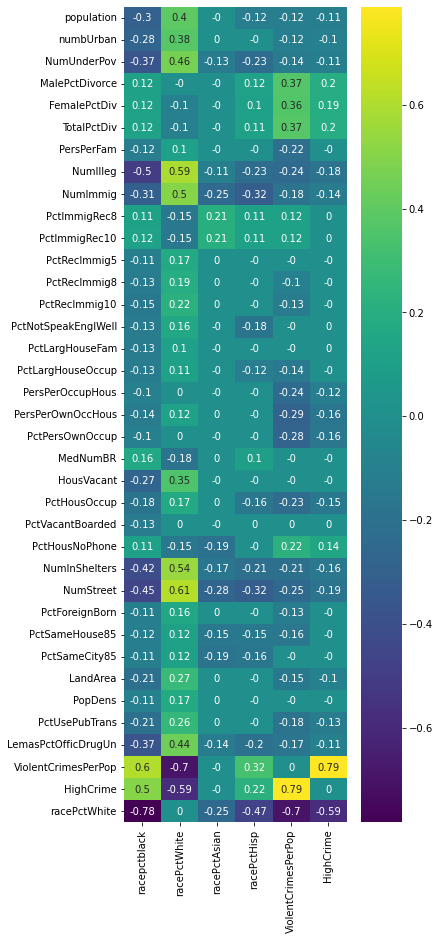

In [35]:
fig, ax = plt.subplots(1, figsize=(5,15))
sns.heatmap(speaman_corr[protected_cols + y_cols].loc[speaman_corr.racepctblack != 0,:], center=0, annot=True, cmap="viridis")

# Comparing the original data vs. debiased with (Makes no sense)

In [36]:
org_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,HighCrime
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20,0
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67,1
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43,1
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12,0
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03,0


In [37]:
debias_df.head()

,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,...,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,HighCrime,racepctblack,racePctWhite,racePctAsian,racePctHisp
0,1.211200,-0.825666,-0.453621,-0.043592,-0.167027,-0.599999,1.225020,0.715991,-0.108441,0.808032,...,0.594946,0.248128,0.313259,1.091348,0.20,0,0.02,0.90,0.12,0.17
1,-0.595751,-1.860320,-0.917643,0.664519,0.064086,-0.571901,-0.516720,0.299650,-0.953211,0.380188,...,-0.385178,-0.892509,0.868846,-0.412873,0.67,1,0.12,0.74,0.45,0.07
2,-0.735886,0.005894,-0.261161,-0.270903,-0.460081,-0.671233,-0.782391,-1.666988,-0.064450,0.296250,...,-0.683780,-0.190233,-0.879257,-0.715655,0.43,1,0.49,0.56,0.17,0.04
3,-0.906327,1.983812,0.096416,-0.516344,-0.461448,-1.283200,-0.772562,0.695239,2.207157,2.513039,...,-0.899048,0.397825,0.015050,-1.206802,0.12,0,1.00,0.08,0.12,0.10
4,-0.109897,0.726451,-0.144081,-0.576466,-0.493844,-0.481840,-0.080126,0.538075,0.455951,0.820316,...,-0.124098,-0.390899,-0.410562,-0.144436,0.03,0,0.02,0.95,0.09,0.05


In [38]:
cols = ["PctIlleg", "LemasPctOfficDrugUn", "NumIlleg"]

In [39]:
test_df = debias_df[cols].merge(org_df[cols], suffixes=["_db", "_org"], left_index=True, right_index=True)

In [40]:
test_df[protected_cols[0]] = org_df[protected_cols[0]]

In [41]:
test_pearson = get_significant_correlations(test_df)

<AxesSubplot:>

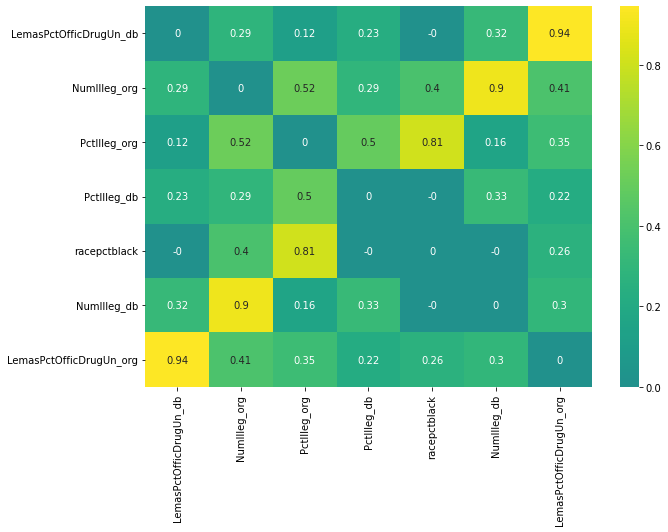

In [42]:
fig, ax = plt.subplots(1, figsize=(10,7))
sns.heatmap(test_pearson, center=0, annot=True, cmap="viridis")

In [43]:
test_spearman = get_significant_correlations(test_df, method="spearman")

<AxesSubplot:>

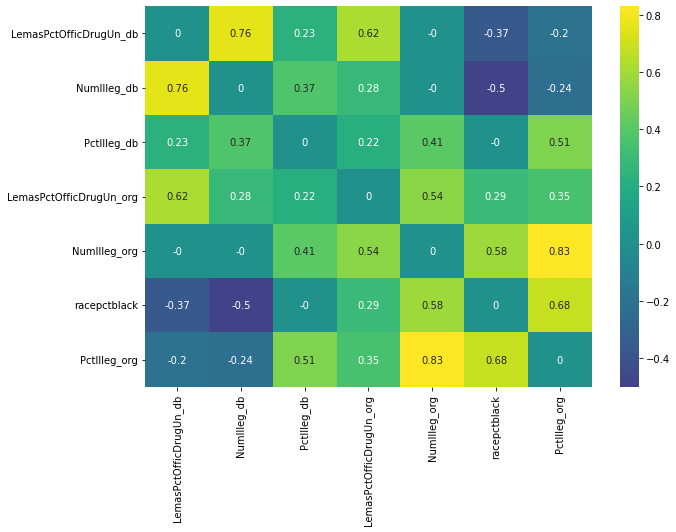

In [44]:
fig, ax = plt.subplots(1, figsize=(10,7))

sns.heatmap(test_spearman, center=0, annot=True, cmap="viridis")

In [45]:
test_df.head()

,PctIlleg_db,LemasPctOfficDrugUn_db,NumIlleg_db,PctIlleg_org,LemasPctOfficDrugUn_org,NumIlleg_org,racepctblack
0,0.027880,1.091348,0.293377,0.14,0.32,0.04,0.02
1,0.287146,-0.412873,-0.289574,0.24,0.00,0.00,0.12
2,0.064451,-0.715655,-0.695373,0.46,0.00,0.01,0.49
3,-2.323491,-1.206802,-1.378288,0.33,0.00,0.03,1.00
4,-0.188768,-0.144436,0.014342,0.06,0.00,0.00,0.02


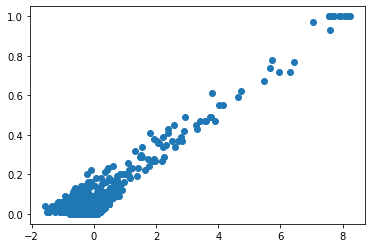

In [46]:
plt.scatter(test_df["NumIlleg_db"], test_df["NumIlleg_org"])

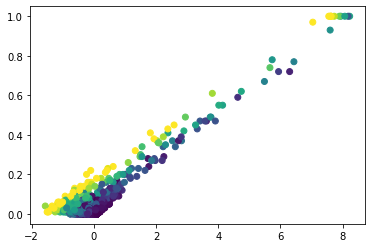

In [47]:
plt.scatter(test_df["NumIlleg_db"], test_df["NumIlleg_org"], c=test_df["racepctblack"])

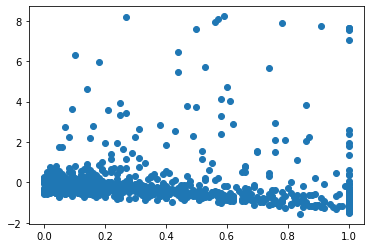

In [48]:
plt.scatter(test_df["racepctblack"], test_df["NumIlleg_db"])

In [49]:
debias_df[protected_cols]

,racepctblack,racePctWhite,racePctAsian,racePctHisp
0,0.02,0.90,0.12,0.17
1,0.12,0.74,0.45,0.07
2,0.49,0.56,0.17,0.04
3,1.00,0.08,0.12,0.10
4,0.02,0.95,0.09,0.05
...,...,...,...,...
1989,0.10,0.87,0.12,0.16
1990,0.46,0.28,0.83,0.32
1991,0.25,0.69,0.04,0.25
1992,0.06,0.87,0.22,0.10


In [50]:
X, y = debias_df[[col for col in debias_df.columns if col not in protected_cols]], debias_df[protected_cols[0]]

In [51]:
from src.model_selection import test_model

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


In [53]:
preds_linear = test_model(LinearRegression, X, y, kfold)
preds_tree = test_model(DecisionTreeRegressor, X, y, kfold)

In [54]:
mean_squared_error(y, preds_linear)

0.037168893709560176

In [55]:
mean_squared_error(y, preds_tree)

0.02290777331995988

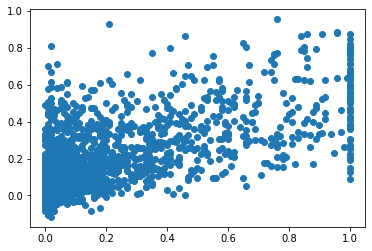

In [56]:
plt.scatter(y, preds_linear)

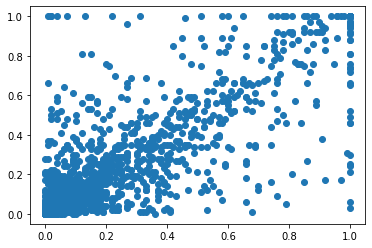

In [57]:
plt.scatter(y, preds_tree)

**NOTE**
Searching for correlations before and after debias makes no sense, as one of the objectives from this technique is to maximise correlation between the feature and its reprojection

# Lambda loop correlation experiments
Looking at the correlation between the protected features and debiased data, with different lambdas.

Purpose is to showcase the effect of lambda and how at lambda 0, there should be no pearsons correlations

In [58]:
from tqdm import tqdm

In [59]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [60]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [61]:
lambda_values = np.linspace(0,1,10)

In [62]:
data_sets = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    db, _ = scaler(X, X)
    data_sets[f"{l_value:.2f}"] = db
    

100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


In [63]:
lambda_res = data_full[protected_cols + y_cols]

In [64]:
data_sets.keys()

dict_keys(['0.00', '0.11', '0.22', '0.33', '0.44', '0.56', '0.67', '0.78', '0.89', '1.00'])

In [65]:
lambda_res = data_full[protected_cols + y_cols]
com_col = "NumIlleg"
lambda_cols = []
for col in data_sets.keys():
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    lambda_res[f"l{col}_{com_col}"] = tmp_df[com_col]
    lambda_cols.append(f"l{col}_{com_col}")

/var/folders/ch/r8kd5mg9455c5w88hpj_xmz80000gn/T/ipykernel_30950/1644855374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda_res[f"l{col}_{com_col}"] = tmp_df[com_col]


<AxesSubplot:>

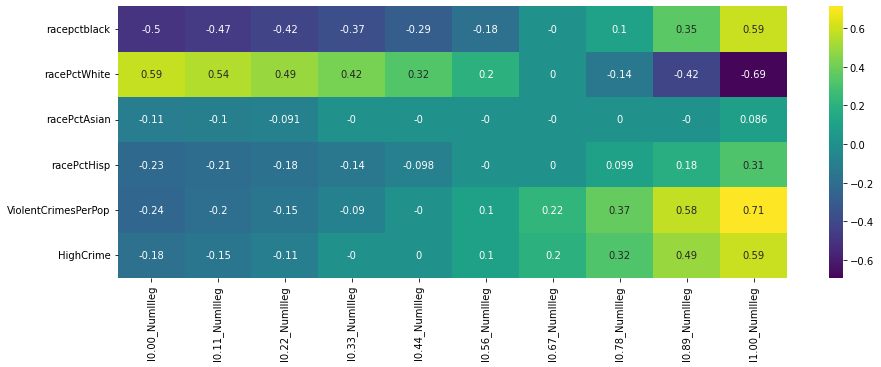

In [66]:
# Speanman corr matrix
speaman_corr = get_significant_correlations(lambda_res, cluster=False, method="spearman")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(speaman_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap="viridis")


<AxesSubplot:>

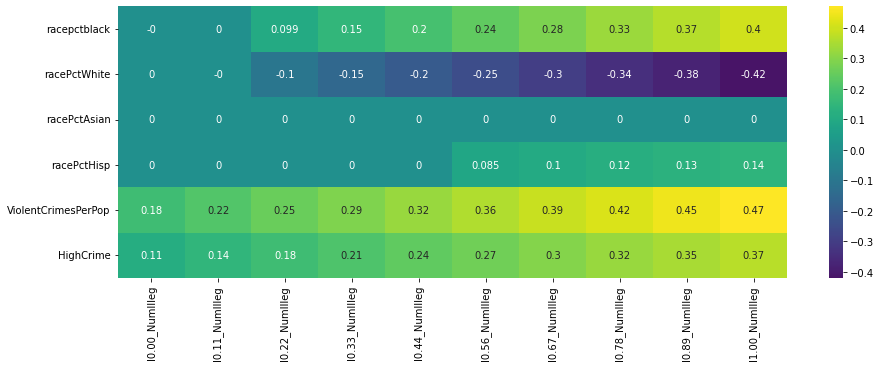

In [67]:
# Speanman corr matrix
pearson_corr = get_significant_correlations(lambda_res, cluster=False, method="pearson")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(pearson_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap="viridis")


In [68]:
protected_cols

['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']

In [70]:
protected_col = "racepctblack"
protected_small_df = data_full[[protected_col]]
pearson_df = pd.DataFrame()
spearman_df = pd.DataFrame()
lambda_cols = []
for col in tqdm(data_sets.keys()):
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    tmp_df = tmp_df.merge(protected_small_df, left_index=True, right_index=True)
    spearman_corr = get_significant_correlations(tmp_df, cluster=False, method="spearman")
    spearman_df[f"l{col}_{protected_col}"] = spearman_corr[[protected_col]]
    pearson_corr = get_significant_correlations(tmp_df, cluster=False, method="pearson")
    pearson_df[f"l{col}_{protected_col}"] = pearson_corr[[protected_col]]
    

  0%|                                                    | 0/10 [00:03<?, ?it/s]


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

### Pearsons correlations between racepctblack and the debiased data with different lambda

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,25))
sns.heatmap(pearson_df, center=0, annot=True, cmap="viridis")

**NOTE**
With lambda 0 is the dataset completely uncorrelated regarding pearsons correlation

### Spearman correlations between racepctblack and the debiased data with different lambda

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,25))
sns.heatmap(spearman_df, center=0, annot=True, cmap="viridis")

**NOTE**
At no point is dataset completely uncorrelated regarding spearman correlations.
This means that as long one uses a model which can interperet ranking, the model is not able to make decisions without influence of the protected attributes, regardless of the lambda value